# Prior predictive check

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
np.random.seed(123456)

import sys; sys.path.append("..")
from epimodel import EpidemiologicalParameters
from epimodel.pymc3_models.mask_models import RandomWalkMobilityModel, MandateMobilityModel
from epimodel.preprocessing.preprocess_mask_data import Preprocess_masks
import epimodel.viz.region_plot as rp
import epimodel.viz.prior_posterior as pp
import epimodel.viz.yougov as yg
import epimodel.viz.pred_cases as pc
import epimodel.viz.result_plot as rep
import epimodel.viz.mandate_wearing as mw
import epimodel.viz.empirical_wearing as ew

import calendar 
import theano.tensor as T
import theano.tensor.signal.conv as C
import theano

import pymc3 as pm
import pandas as pd
import copy
import re
import pickle
import datetime
from datetime import timedelta
import argparse
from pathlib import Path
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import arviz as az
import json

sns.set(style="ticks", font='DejaVu Serif')
PNAS_WIDTH_INCHES = 3.4252


Set Theano Environmental Variables for Parallelisation


In [2]:
MODEL = "cases" #args.model
MASKS = "wearing" #args.masks
W_PAR = "exp" #args.w_par

n_mandates = 2

MOBI = 'include' # args.mob
US = True
SMOOTH = False
GATHERINGS = 3 #args.gatherings if args.gatherings else 3
# MASKING = True # Always true

if MODEL == "both":
    TUNING = 2500
else:
    TUNING = 2000

Ds = pd.date_range("2020-05-01", "2020-09-21", freq="D")

In [3]:
path = f"../data/modelling_set/master_data_mob_{MOBI}_us_{US}_m_w.csv"
masks_object = Preprocess_masks(path=path)

masks_object.featurize(gatherings=GATHERINGS, masks=MASKS, smooth=SMOOTH, mobility=MOBI, n_mandates = 2)
masks_object.make_preprocessed_object()
data = masks_object.data

['C1_School closing', 'C1_School closing_full', 'C2_Workplace closing', 'C2_Workplace closing_full', 'C4_Restrictions on gatherings_3plus', 'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 'C4_Restrictions on gatherings_2plus', 'C4_Restrictions on gatherings_full', 'avg_mobility_no_parks_no_residential', 'percent_mc']
Masking May cases in US states
centering NPIs


In [4]:
ep = EpidemiologicalParameters()
bd = ep.get_model_build_dict()


def set_init_infections(data, d):
    n_masked_days = 10
    first_day_new = data.NewCases[:, n_masked_days]
    first_day_new = first_day_new[first_day_new.mask == False]
    median_init_size = np.median(first_day_new)

    if median_init_size == 0:
        median_init_size = 50

    d["log_init_mean"] = np.log(median_init_size)
    d["log_init_sd"] = np.log(median_init_size)  # TODO: wide


set_init_infections(data, bd)

bd['wearing_parameterisation'] = W_PAR


### TODO
bd["intervention_prior"] = "normal"


if MODEL == "cases":
    del bd["deaths_delay_mean_mean"]
    del bd["deaths_delay_mean_sd"]
    del bd["deaths_delay_disp_mean"]
    del bd["deaths_delay_disp_sd"]

    
if MASKS == "mandate":
    bd['n_mandates'] = 1
    #bd['mask_mean'] = 0.2 / bd['n_mandates']
    bd['mask_sigma'] = 0.2


/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [6]:
r_walk_period=7
r_walk_noise_scale_prior=0.15
intervention_prior="AL"
cm_prior_scale=10
wearing_parameterisation="exp"
wearing_mean=0
wearing_mean_linear=0
wearing_mean_quadratic=0
wearing_sigma=0.4
wearing_sigma_linear=0.26
wearing_sigma_quadratic=0.13
mobility_mean=1.704
mobility_sigma=0.44
R_prior_mean_mean=1.07
R_prior_mean_scale=0.2
R_noise_scale=0.4  
cm_prior="skewed"
gi_mean_mean=5.06
gi_mean_sd=0.33
gi_sd_mean=2.11
gi_sd_sd=0.5
cases_delay_mean_mean=10.92
cases_delay_disp_mean=5.41
cases_truncation=32
log_init_mean=9.9
log_init_sd=9.9
IGNORE_START=10
IGNORE_END=10
mobility_leaveout=False
mob_and_wearing_only=False

nCMs = len(data.CMs)
nRs = len(data.Rs)
nDs = len(data.Ds)


observed_active = []

for r in range(nRs):
    for d in range(nDs):
        # if its not masked, after the cut, and not before 100 confirmed
        if (
            data.NewCases.mask[r, d] == False
            # and d > self.CMDelayCut
            and not np.isnan(data.Confirmed.data[r, d])
        ):
            observed_active.append(r * nDs + d)
        else:
            data.NewCases.mask[r, d] = True
print(len(observed_active))
all_observed_active = np.array(observed_active)


10429


In [ ]:
with pm.Model() as model:
    # build NPI Effectiveness priors
    CM_Alpha = pm.Normal(
        "CM_Alpha", mu=0, sigma=cm_prior_scale, shape=(nCMs - 2,)
    )

    CMReduction = pm.Deterministic(
        "CMReduction", T.exp((-1.0) * CM_Alpha)
    )
    
    Wearing_Alpha = pm.Normal(
        "Wearing_Alpha", mu=wearing_mean, sigma=wearing_sigma# , shape=(1,)
    )
    WearingReduction = pm.Deterministic(
        "WearingReduction", T.exp((-1.0) * Wearing_Alpha)
    )

    Mobility_Alpha = pm.Normal(
        "Mobility_Alpha", mu=mobility_mean, sigma=mobility_sigma#, shape=(1,)
    )
    MobilityReduction = pm.Deterministic(
        "MobilityReduction",
        (2.0 * (T.exp(-1.0 * Mobility_Alpha)))
        / (1.0 + T.exp(-1.0 * Mobility_Alpha)),
    )

    HyperRMean = pm.TruncatedNormal(
        "HyperRMean", mu=R_prior_mean_mean, sigma=R_prior_mean_scale, lower=0.1
    )

    HyperRVar = pm.HalfNormal("HyperRVar", sigma=R_noise_scale)

    RegionR_noise = pm.Normal("RegionR_noise", 0, 1, shape=(nRs,))
    RegionR = pm.Deterministic(
        "RegionR", HyperRMean + RegionR_noise * HyperRVar
    )

    # load CMs active without wearing, compute log-R reduction and region log-R based on NPIs active
    ActiveCMs = pm.Data("ActiveCMs", data.ActiveCMs[:, :-2, :])

    ActiveCMReduction = (
        T.reshape(CM_Alpha, (1, nCMs - 2, 1)) * ActiveCMs
    )

    ActiveCMs_wearing = pm.Data(
        "ActiveCMs_wearing", data.ActiveCMs[:, -1, :]
    )
    
    growth_reduction = T.sum(ActiveCMReduction, axis=1)

    if mob_and_wearing_only:
        growth_reduction = 0
    else:
        pm.Deterministic("growth_reduction", growth_reduction)

    # calculating reductions for each of the wearing parameterisations
    if wearing_parameterisation == "exp":
        ActiveCMReduction_wearing = T.reshape(
            Wearing_Alpha, (1, 1, 1)
        ) * T.reshape(
            ActiveCMs_wearing,
            (data.ActiveCMs.shape[0], 1, data.ActiveCMs.shape[2]),
        )
        growth_reduction_wearing = T.sum(ActiveCMReduction_wearing, axis=1)

    if wearing_parameterisation == "log_linear":
        ActiveCMReduction_wearing = T.reshape(
            Wearing_Alpha, (1, 1, 1)
        ) * T.reshape(
            ActiveCMs_wearing,
            (data.ActiveCMs.shape[0], 1, data.ActiveCMs.shape[2]),
        )
        eps = 10 ** (-20)
        growth_reduction_wearing = -1.0 * T.log(
            T.nnet.relu(1.0 - T.sum(ActiveCMReduction_wearing, axis=1))
            + eps
        )

    if wearing_parameterisation == "log_quadratic":
        ActiveCMReduction_wearing = (
            T.reshape(Wearing_Alpha, (1, 1, 1))
            * T.reshape(
                ActiveCMs_wearing,
                (data.ActiveCMs.shape[0], 1, data.ActiveCMs.shape[2]),
            )
            + T.reshape(Wearing_Alpha, (1, 1, 1))
            * T.reshape(
                ActiveCMs_wearing,
                (data.ActiveCMs.shape[0], 1, data.ActiveCMs.shape[2]),
            )
            ** 2
        )
        eps = 10 ** (-20)
        growth_reduction_wearing = -1.0 * T.log(
            T.nnet.relu(1.0 - T.sum(ActiveCMReduction_wearing, axis=1))
            + eps
        )
    
    if wearing_parameterisation == "log_quadratic_2":
        ActiveCMReduction_wearing = (
            T.reshape(Wearing_Alpha[0], (1, 1, 1))
            * T.reshape(
                ActiveCMs_wearing,
                (data.ActiveCMs.shape[0], 1, data.ActiveCMs.shape[2]),
            )
            + T.reshape(Wearing_Alpha[1], (1, 1, 1))
            * T.reshape(
                ActiveCMs_wearing,
                (data.ActiveCMs.shape[0], 1, data.ActiveCMs.shape[2]),
            )
            ** 2
        )
        eps = 10 ** (-20)
        growth_reduction_wearing = -1.0 * T.log(
            T.nnet.relu(1.0 - T.sum(ActiveCMReduction_wearing, axis=1))
            + eps
        )
    if wearing_parameterisation is None:
        growth_reduction_wearing = 0
    else:
        pm.Deterministic("growth_reduction_wearing", growth_reduction_wearing)

    # make reduction for mobility
    ActiveCMs_mobility = pm.Data(
        "ActiveCMs_mobility", data.ActiveCMs[:, -2, :]
    )

    ActiveCMReduction_mobility = T.reshape(
        Mobility_Alpha, (1, 1, 1)
    ) * T.reshape(
        ActiveCMs_mobility,
        (data.ActiveCMs.shape[0], 1, data.ActiveCMs.shape[2]),
    )

    growth_reduction_mobility = -1.0 * T.log(
        T.sum(
            (2.0 * T.exp(-1.0 * ActiveCMReduction_mobility))
            / (1.0 + T.exp(-1.0 * ActiveCMReduction_mobility)),
            axis=1,
        )
    )

    initial_mobility_reduction = growth_reduction_mobility[:, 0]
    initial_mobility_reduction = T.reshape(initial_mobility_reduction, (nRs, 1))
    pm.Deterministic("initial_mobility_reduction", initial_mobility_reduction)

    pm.Deterministic("growth_reduction_mobility", growth_reduction_mobility)

    # random walk
    nNP = int(nDs / r_walk_period) - 1

    r_walk_noise_scale = pm.HalfNormal(
        "r_walk_noise_scale", r_walk_noise_scale_prior
    )
    # rescaling variables by 10 for better NUTS adaptation
    r_walk_noise = pm.Normal("r_walk_noise", 0, 1.0 / 10, shape=(nRs, nNP))

    expanded_r_walk_noise = T.repeat(
        r_walk_noise_scale * 10.0 * T.cumsum(r_walk_noise, axis=-1),
        r_walk_period,
        axis=-1,
    )[: nRs, : (nDs - 2 * r_walk_period)]

    full_log_Rt_noise = T.zeros((nRs, nDs))
    full_log_Rt_noise = T.subtensor.set_subtensor(
        full_log_Rt_noise[:, 2 * r_walk_period :], expanded_r_walk_noise
    )

    ExpectedLogR = pm.Deterministic(
        "ExpectedLogR",
        T.reshape(pm.math.log(RegionR), (nRs, 1))
        - growth_reduction
        - growth_reduction_wearing
        - (growth_reduction_mobility - initial_mobility_reduction)
        + full_log_Rt_noise,
    )

    Rt_walk = pm.Deterministic(
        "Rt_walk",
        T.exp(T.log(RegionR.reshape((nRs, 1))) + full_log_Rt_noise),
    )

    Rt_cm = pm.Deterministic(
        "Rt_cm",
        T.exp(
            T.log(RegionR.reshape((nRs, 1)))
            - growth_reduction
            - growth_reduction_wearing
        ),
    )

    # convert R into growth rates
    GI_mean = pm.Normal("GI_mean", gi_mean_mean, gi_mean_sd)
    GI_sd = pm.Normal("GI_sd", gi_sd_mean, gi_sd_sd)

    gi_beta = GI_mean / GI_sd ** 2
    gi_alpha = GI_mean ** 2 / GI_sd ** 2

    ExpectedGrowth = pm.Deterministic(
        "ExpectedGrowth",
        gi_beta
        * (
            np.exp(ExpectedLogR / gi_alpha)
            - T.ones_like(ExpectedLogR)
        ),
    )

    Growth = ExpectedGrowth

    # Originally N(0, 50)
    InitialSize_log = pm.Normal(
        "InitialSize_log", log_init_mean, log_init_sd, shape=(nRs,)
    )
    Infected_log = pm.Deterministic(
        "Infected_log",
        T.reshape(InitialSize_log, (nRs, 1))
        + Growth.cumsum(axis=1),
    )

    Infected = pm.Deterministic("Infected", pm.math.exp(Infected_log))

    cases_delay_dist = pm.NegativeBinomial.dist(
        mu=cases_delay_mean_mean, alpha=cases_delay_disp_mean
    )
    bins = np.arange(0, cases_truncation)
    pmf = T.exp(cases_delay_dist.logp(bins))
    pmf = pmf / T.sum(pmf)
    reporting_delay = pmf.reshape((1, cases_truncation))

    expected_confirmed = C.conv2d(
        Infected, reporting_delay, border_mode="full"
    )[:, : nDs]

    ExpectedCases = pm.Deterministic(
        "ExpectedCases", expected_confirmed.reshape((nRs, nDs))
    )

    # Observation Noise Dispersion Parameter (negbin alpha)
    Psi = pm.HalfNormal("Psi", 5)

    # effectively handle missing values ourselves
    # likelihood
#     ObservedCases = pm.NegativeBinomial(
#         "ObservedCases",
#         mu=ExpectedCases.reshape((nRs * nDs,))[
#             all_observed_active
#         ],
#         alpha=Psi,
#         shape=(len(all_observed_active),),
# #         observed=data.NewCases.data.reshape((nRs * nDs,))[
# #             all_observed_active
# #         ],
#     )
    
    ppc_trace = pm.sample_prior_predictive(samples=1000)
    


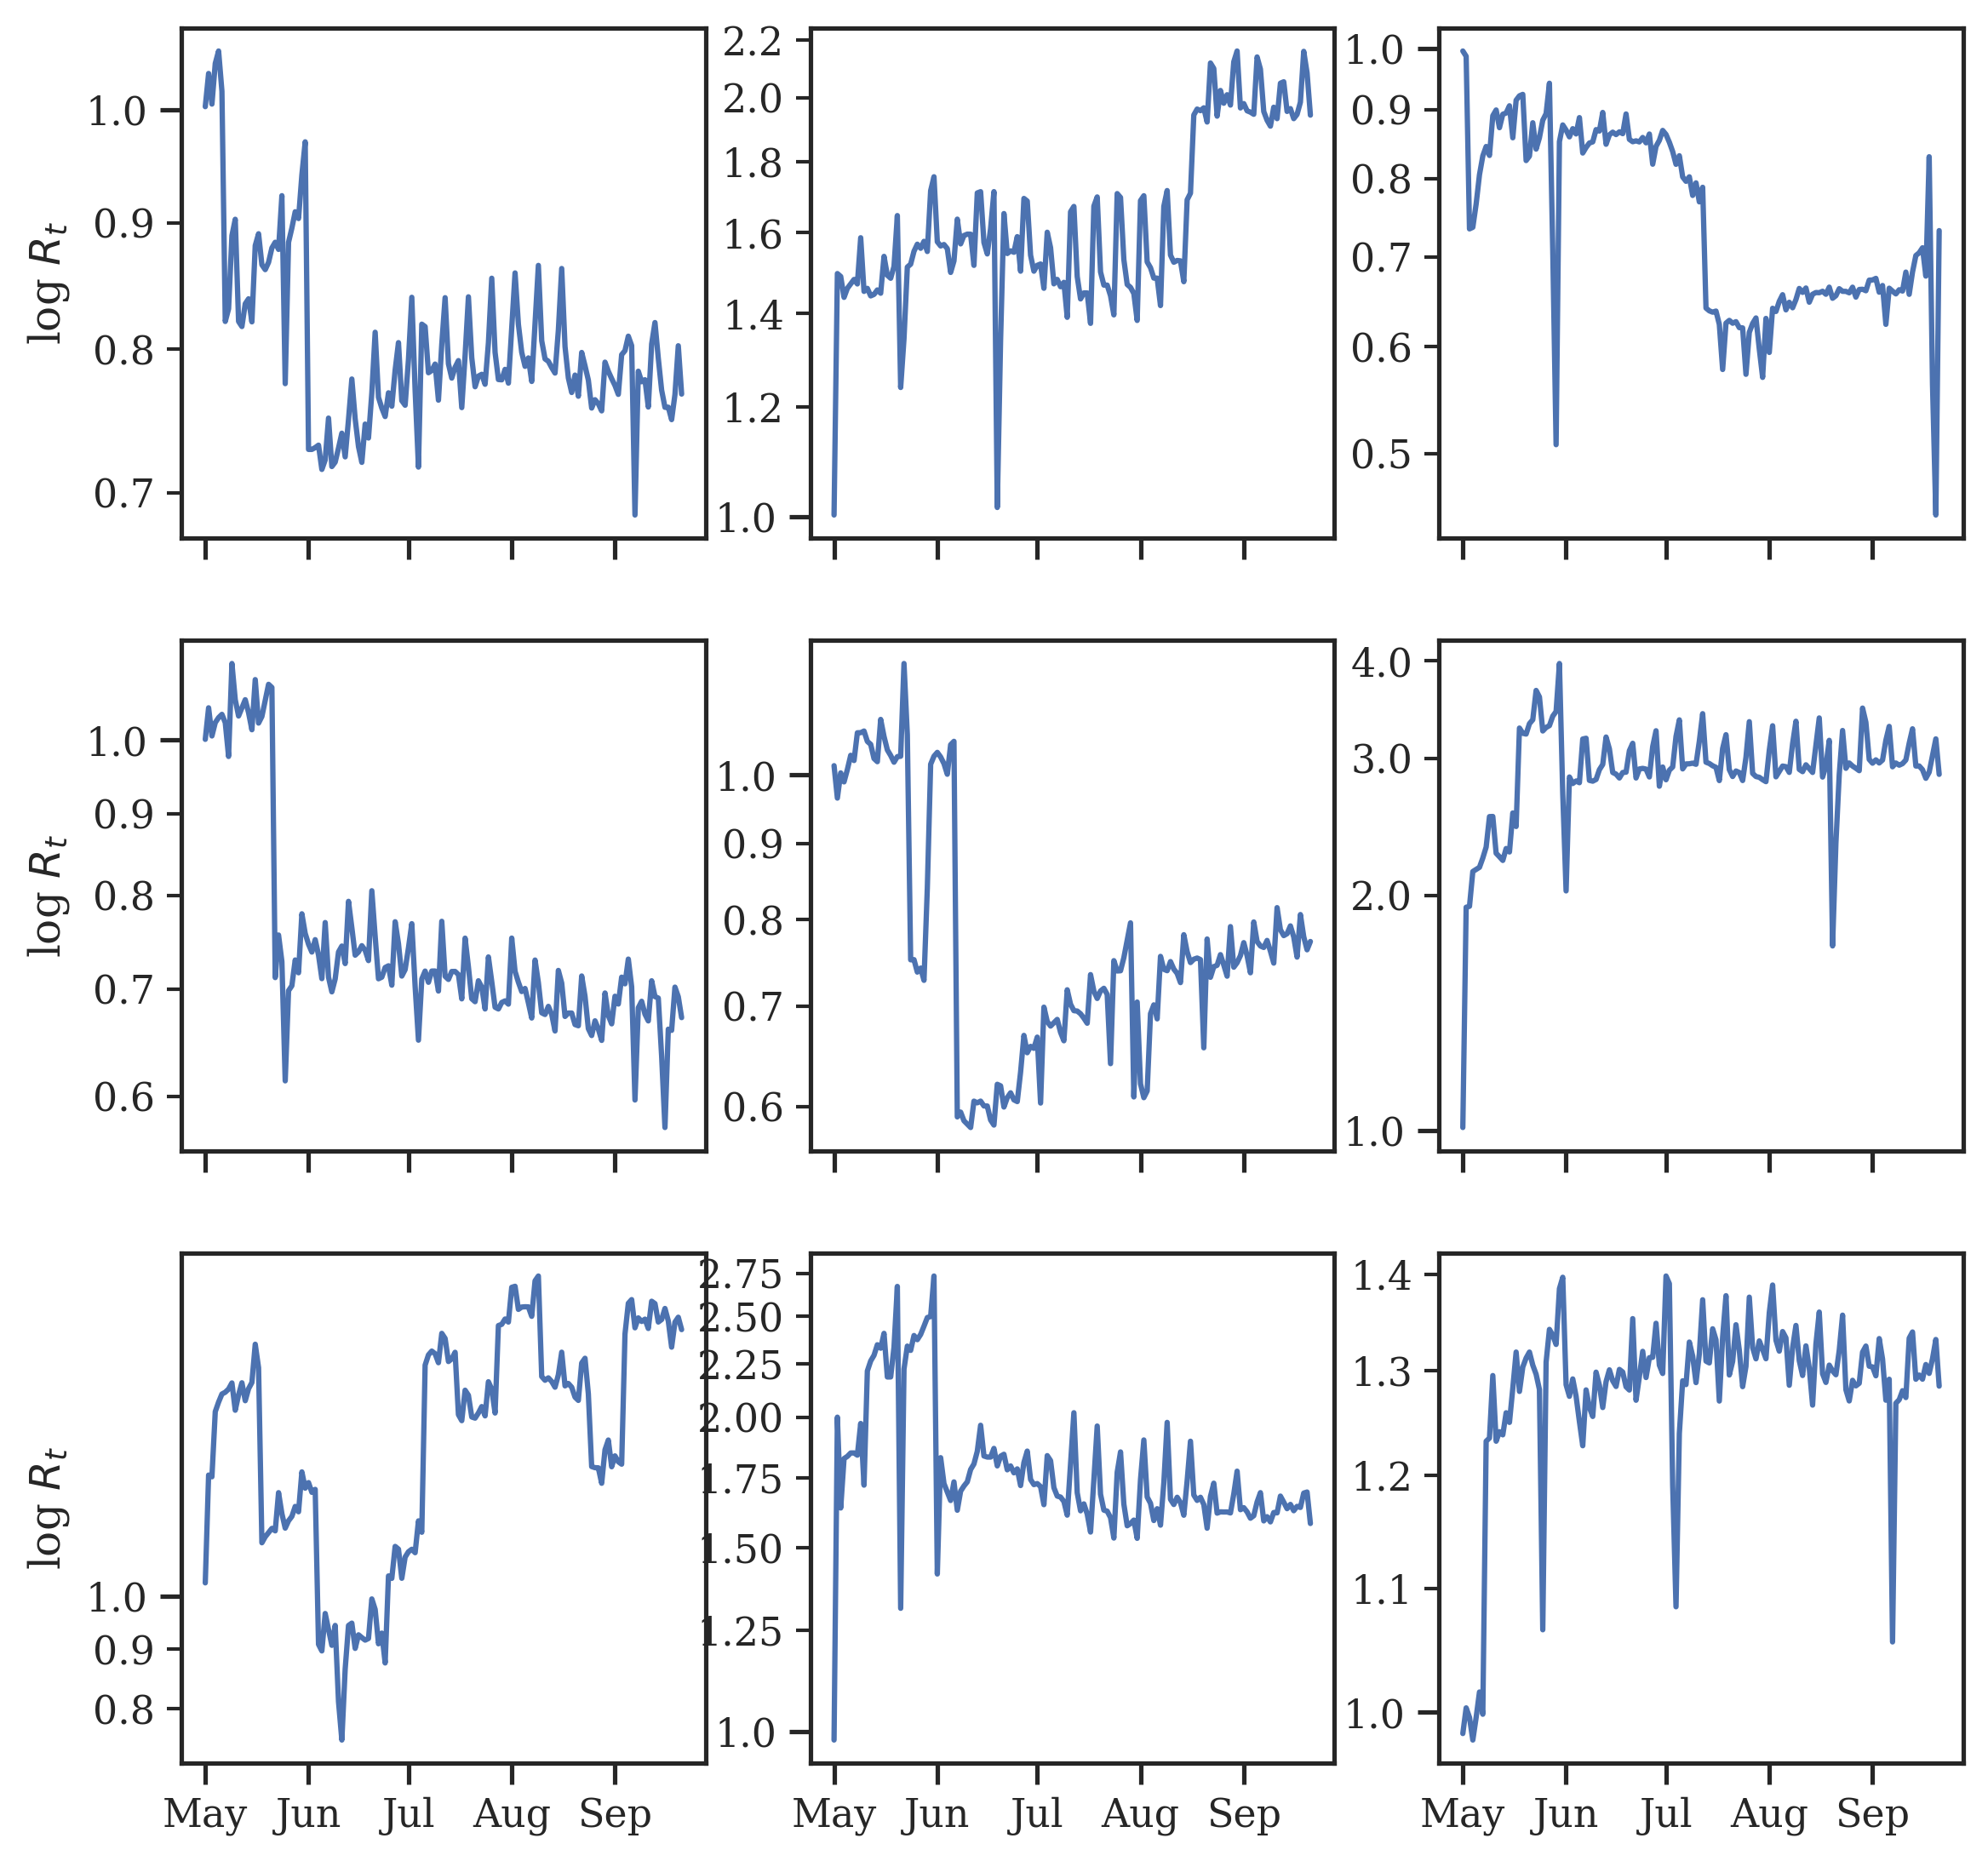

In [213]:
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
from random import randrange
import matplotlib.ticker as mticker



Ds = pd.date_range("2020-05-01", "2020-09-21", freq="D")

f, (x, y, z) = plt.subplots(3, 3, figsize=(9,9), dpi=300, sharex=True)


def plot_r(i, ax, y=False):
    r = np.exp(np.nanmean(ppc_trace["ExpectedLogR"], axis=0))
    ax.plot(Ds, r[i,:])
    if y :
        ax.set_ylabel("log $R_t$")
    locator = mdates.MonthLocator()  # every month
    fmt = mdates.DateFormatter('%b')
    
    X = plt.gca().xaxis
    X.set_major_locator(locator)
    X.set_major_formatter(fmt)
    Y = plt.gca().yaxis
    ax.set_yscale("log")
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))



plot_r(randrange(92), x[0], y=True)
plot_r(randrange(92), x[1])
plot_r(randrange(92), x[2])
plot_r(randrange(92), y[0], y=True)
plot_r(randrange(92), y[1])
plot_r(randrange(92), y[2])
plot_r(randrange(92), z[0], y=True)
plot_r(randrange(92), z[1])
plot_r(randrange(92), z[2])

#plt.suptitle("Prior predictive checks: sample $R_t$ curves")




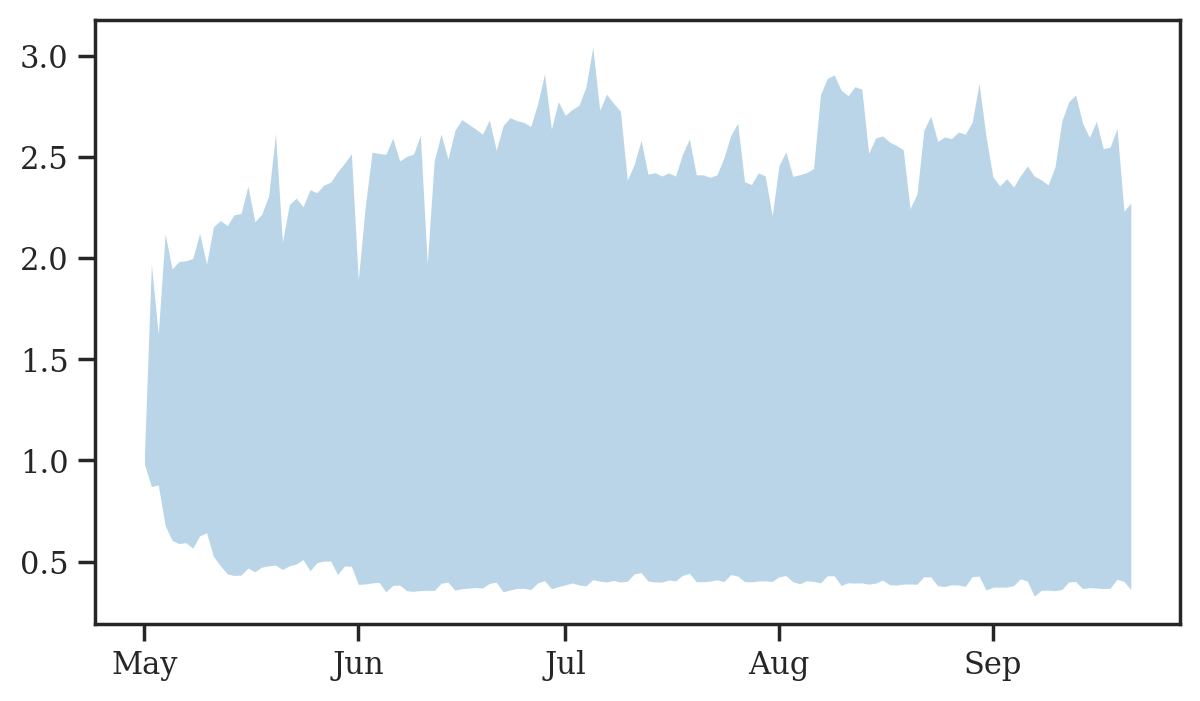

In [223]:
plt.subplots(figsize=(7,4), dpi=200)
r = np.exp(np.nanmean(ppc_trace["ExpectedLogR"], axis=0))
#plt.plot(Ds, r[i,:])
l = np.percentile(r, 2.5, axis=0)
u = np.percentile(r, 97.5, axis=0)
plt.fill_between(Ds, l, u, alpha=0.3, color="tab:blue", linewidth=0)

X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)
plt.show()

In [103]:
np.nanmean(ppc_trace["GI_mean"], axis=0), \
np.nanmean(ppc_trace["GI_sd"], axis=0)

# gi_alpha ~= 6.5

(5.069519828384771, 2.112503360742309)

In [142]:
np.exp(ppc_trace["InitialSize_log"].mean())

20209.032280375613

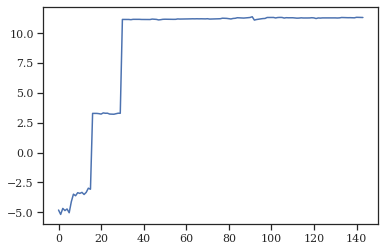

In [107]:
ci = 4
r = np.log(np.nanmean(ppc_trace["ExpectedGrowth"], axis=0))
plt.plot(r[ci,:])

In [ ]:
pred_rs = ["Australia", "United Kingdom", "Nigeria", "Singapore"] 
f, (rowax, colax) = plt.subplots(2, 2, figsize=(10,6), dpi=500, sharex=True)
# pc.epicurve_plot(data, oxcgrt, Ds, ppc_trace, pred_rs[0], rowax[0], leg=True)
# pc.epicurve_plot(data, oxcgrt,  Ds, ppc_trace, pred_rs[1], rowax[1])
# pc.epicurve_plot(data, oxcgrt,  Ds, ppc_trace, pred_rs[2], colax[0])
# pc.epicurve_plot(data, oxcgrt,  Ds, ppc_trace, pred_rs[3], colax[1])